# Exploration 4. 프로젝트: 멋진 작사가 만들기


라이브러리 불러오기

In [1]:
import os, re, glob
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split


### __preprocess_sentence__ (문장을 전처리하는 함수)

- __소문자로 바꾸기(lower함수 사용)__  
    : 대문자가 섞인 단어와 소문자로만 이루어진 단어가 한 단어로 인식되도록 만들어주는 작업이다. 예를들어 Love와 love를 그냥 입력하면 다른 단어로 받아들여지게 되므로 소문자로 바꿔주는 작업을 한다
- __문장부호를 단어와 분리하기(정규표현식 함수 re.sub에 정규표현식 r"([?.!,¿])", r" \1"사용)__  
    : 같은 단어에 하나는 문장부호가 들어있고 한쪽은 없는 경우에도 다른 단어로 인식하기 때문에 문장부호를 단어와 스페이스바로 여백을 주어서 분리한다. 예를 들어 "How old are you?"의 you와 "you are..." 두 문장에서 you는 같은 you이지만 처음 것은 물음표가 있고 뒤에 것은 물음표가 없지만 같은 you이다. 하지만 물음표가 붙어있으면 컴퓨터에서는 둘을 다른 단어로 인식하게 된다. 그래서 전처리 과정에서 분리한다.
- __여러개의 공백을 하나의 공백으로 변환__(정규표현식 함수 re.sub에 정규표현식 r'[" "]+', " " 사용)
    : [" "]+ 이 정규표현식은 공백이 둘 이상 있는 경우를 의미하고 이럴 경우 하나의 띄어쓰기로 바꿔준다는 뜻이다   
    ex) long-time-ago. (한단어로 인식한다. 띄어쓰기가 아니라 -를 기준으로 단어가 나뉘므로)
    


자연어처리 분야에서 __모델의 입력문장을 소스문장(Source Sentence)__ , 정답이 되는 __모델의 출력문장을 타겟문장(Target sentence)__ 라고 부른다. X_train, y_train에 해당한다. 그래서 문장의 시작에  start 끝에 end를 넣었다. 

In [2]:
def preprocess_sentence(sentence):
    sentence=sentence.strip().lower() # 문장의 앞뒤 공백을 지우고 소문자 변환
    sentence=re.sub(r"([?.!,¿])", r" \1", sentence)  # 특수문자의 양 옆을 각각 한칸 띄우고
    sentence=re.sub(r'[" "]+', " ", sentence) # 여러개의 공백은 하나의 공백으로 바꿉니다.
    sentence=re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 
    #특수문자는 하나의 공백으로 바꾼다.
    sentence=sentence.strip() # 문자열에 양끝의 공백을 한번 더 삭제
    sentence=" ".join(['<start> ',sentence,' <end>']) # 문장시작은 <start> 끝에는 <end>를 추가한다.
    return sentence



preprocess_sentence 함수 내의 정규표현식 re.sub를 어떻게 쓰는지 궁금해서 테스트를 해보았다.  

re.sub(정규표현식, 바꿀 문자, 적용할 문장 )
- re.sub 함수는 적용할 문장에 정규표현식에 해당하는 문자를 찾아서 바꿀 문자로 바꿔주는 함수이다.

In [3]:
#a-zA-Z?.!,¿가 아닌 모든 특수문자를 하나의 공백으로 바꾼다.

s="Does 100% pure water have a taste"
s=re.sub(r"[^a-zA-Z?.!,¿]+", " ",s) 
print(s) 

Does pure water have a taste


바로 위에 있는 셀의 r"[^a-zA-Z?.!,¿]+"는 대괄호 안의 맨 앞에 __메타문자 ^__ 가 있다. 이 메타문자는 __not이라는 의미__ 를 갖고 있다. 그래서 대괄호 안에 있는 __소문자(a-z) 대문자(A-Z) 문장기호 (?.!,¿)가 아닌 문자로 이루어진 것__ 을 삭제하게 된다.  
그래서 s에 저장된 문자열에서 100% 단어가 공백으로 바뀐다.

In [4]:
# 위의 preprocess_sentence 함수에 문자열을 넣으면 다음과 같이 전처리가 된다.
print(preprocess_sentence("Hi, My name is sunny 100%"))

<start>  hi , my name is sunny  <end>


왜 문장의 처음과 끝에 start와 end 넣는 이유는 시퀀스 문장의 시작과 끝이 어디인지를 학습시키기 위해서 태그를 해준다. 
우리가 구축해야하는 데이터셋의 모양은?
- 언어모델 입력문장: \<start\> 나는 밥을 먹었다 
- 언어모델 출력문장: 나는 밥을 먹었다 \<end\>

자연어처리 분야에서 __모델의 입력문장을 소스문장(Source Sentence)__ , 정답이 되는 __모델의 출력문장을 타겟문장(Target sentence)__ 라고 부른다. X_train, y_train에 해당한다.

### tokenize(문장을 토큰으로 만드는 함수)
 - 문장을 토큰화 했을 때 토큰의 개수가 15개 넘어가는 문장을 제외하였다.  

 - 앞에서 전처리한 문장을 띄어쓰기를 기준으로 잘라내어 토큰으로 만들어서 vectorize 시킨다. 
 토큰: 단어를 의미를 갖는 가장 짧은 단위로 자르는 것
 vectorize: 토큰으로 만든 문장을 단어사전의 숫자에 맞게 매칭을 시켜주어서 벡터로 만드는 것.

텐서플로우의 Tokenizer 패키지
- 위의 정제된 corpus를 토큰화해서 단어사전(vocabulary or dictionary)라고 말하며 숫자로 변환해준다. 이 과정을 벡터화(vectorize)이고, 숫자로 바꾼 데이터를 tensor라고 말한다.

tf.keras.preprocessing.text.Tokenizer
[참고할 사이트](https://wikidocs.net/31766)


In [5]:
def tokenize(corpus): 
    tokenizer=tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 단어장 크기12000
        filters=' ',     # preprocessed_sentence
        oov_token="<unk>"
    )
    # corpus를 사용해서 tokenizer 단어장을 만든다. 
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 사용해서 corpus를 Tensor로 만든다.
    tensor=tokenizer.texts_to_sequences(corpus)
    
    tensor_=[]

    for i in tensor:
        if len(i)<=15:   # 15개 
            tensor_.append(i)
    # input data의 시퀀스 크기를 
    #(길이가 짧은 문장 뒤(post)에 padding을 붙여서) 동일하게 만든다.
    # 문장 앞에 패딩을 붙이려면 pre라고 입력하면 됨
    tensor=tf.keras.preprocessing.sequence.pad_sequences(tensor_, padding='post')
                
    print(tensor, tokenizer)
    return tensor, tokenizer

### __TextGenerator (케라스의 LSTM을 사용한 텍스트 생성기 모델)__

- keras.layers.Embedding(input_dim, output_dim)  
> input_dim: 단어사전의 크기+1  
> output_dim: 임베딩 차원의 크기

- tf.keras.layers.LSTM(units,return_squences=True)
> units: 양의 정수, out space의 차원  
> activation: 따로 입력하지 않았으므로 기본값인 hyperbolic tangent  
> return_sequence: 아웃풋 시퀀스의 마지막 아웃풋을 반환할지, 시퀀스 전체를 반환할지를 정한다. 코드에서는 True가 적혀 있으므로 시퀀스 전체를 반환한다.

In [6]:
class TextGenerator(tf.keras.Model): # keras의 Model 클래스를 오버라이딩한다.
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__() 
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out



### __generate_text__ (마지막으로 가사를 생성시킬 함수)


In [7]:
    
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환.(입력 문장)
    
    test_input = tokenizer.texts_to_sequences([init_sentence]) # tokenizer를 사용해서 init_sentence를 시퀀스 데이터로 바꿈
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)  # 시퀀스 데이터를 텐서로 바꾼다.
    
    end_token = tokenizer.word_index["<end>"]  # "<end>"에 해당하는 index를 end_token에 반환한다

    # 단어 하나씩 예측해 문장을 만듭니다

    while True: # 4번 조건에 의해서 while 반복문을 끝내기 전까지 반복해라

        # 1 . 입력받은 문장의 텐서를 입력합니다
        predict = model(test_tensor)
        
        # 2 . 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        
        # 3 . 2에서 예측된 word index를 문장 뒤에 붙입니다
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        
        # 4 . 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
        if predict_word.numpy()[0] == end_token: break # 예측한 단어가 end에 해당하는 인덱스 번호와 같으면 끝내기
        if test_tensor.shape[1] >= max_len: break 

    generated = ""

    # while문으로 인해 만들어진 test_tensor를 tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy(): 
        generated += tokenizer.index_word[word_index] + " " 

    return generated


### step1. 데이터 다운로드 & Step2. 데이터 읽어오기
- 아이펠에서 제공한 가사데이터를 다운받는다.


In [8]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)
print(txt_file_path)
raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])


/aiffel/aiffel/lyricist/data/lyrics/*
데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


### step 3. 데이터 정제

text_to_sequences 메서드를 사용해서 텍스트를 시퀀스형 데이터인 리스트로 만들어낸다. 2차원 리스트의 모양으로 데이터를 반환한다

데이터가 preprocess_sentence 함수에 의해 처리되면서 문장의 앞에 start 뒤에 end가 붙게 된다. 모델을 학습시킬 문장에는 end를 빼기 위해서 -1인덱스까지 자르고, 타겟문장에는 start를 잘라내기 위해서 1번 인덱스부터 끝의 문장까지 슬라이싱한다.

In [9]:
corpus=[]

for sentence in raw_corpus:
    if len(sentence) == 0: continue    # 빈 단어를 corpus에서 뺀다
    if sentence[-1] == ":" : continue  # 끝에 콜론이 있는 다
        
    # 앞에서 문장부호와 특수문자, 소문자 대문자 처리
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    

tensor, tokenizer=tokenize(corpus)     # 전처리가 끝난 corpus를 tokenize 함수를 적용해서 텐서와 tokenizer를 반환받는다.

[[   2   50    5 ...    0    0    0]
 [   2   17 2643 ...    0    0    0]
 [   2   35    7 ...   44    3    0]
 ...
 [   2    5  107 ...    0    0    0]
 [   2  261  202 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f62edcacbb0>


In [10]:
tensor.shape

(156074, 15)

tokenize 함수 내부의 과정이 궁금해서 조금 뜯어보았다.

In [11]:
tokenizerA=tf.keras.preprocessing.text.Tokenizer(num_words=12000,  # 단어장 크기12000
                                                filters=' ',     # preprocessed_sentence
                                                oov_token="<unk>") # 사전에 없는 단어를 대신 <unk>로 채워준다.
# corpus를 사용해서 tokenizer 단어장을 만든다. 
tokenizerA.fit_on_texts(corpus)

# 준비한 tokenizer를 사용해서 corpus를 Tensor로 만든다. 
# 2차리스트로 결과물이 나온다. 안쪽 리스트의 길이는 문장의 단어 길이이다.

tensor_A=tokenizerA.texts_to_sequences(corpus)

print("corpus를 texts_to_sequences를 적용한 결과")
print("데이터 타입은 ",type(tensor_A),"이고, 문장의 길이에 따라 리스트의 길이가 제각각이 된다.")

# tokenizer를 통해 텍스트를 시퀀스 데이터를 만든 것은 리스트가 된다
print(tensor_A[:4])
print("--------------------------------------------------")
tensorA=[]

for i in tensor_A: # 16미만의 단어로 이루어진 문장만 데이터로 쓰겠다.
    if len(i)<16:
        tensorA.append(i)

tensorA=tf.keras.preprocessing.sequence.pad_sequences(tensorA, padding='post') # 다른 길이의 문장들을 15개의 단어로 통일 시킨다.
print(tensorA, tokenizerA)


corpus를 texts_to_sequences를 적용한 결과
데이터 타입은  <class 'list'> 이고, 문장의 길이에 따라 리스트의 길이가 제각각이 된다.
[[2, 50, 5, 91, 296, 65, 57, 10, 968, 6062, 3], [2, 17, 2643, 872, 4, 8, 11, 6063, 6, 329, 3], [2, 35, 7, 37, 15, 164, 282, 28, 298, 4, 47, 7, 44, 3], [2, 11, 354, 25, 42, 3]]
--------------------------------------------------
[[   2   50    5 ...    0    0    0]
 [   2   17 2643 ...    0    0    0]
 [   2   35    7 ...   44    3    0]
 ...
 [   2    5  107 ...    0    0    0]
 [   2  261  202 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f6313e9d7f0>


In [24]:
print(tensorA.shape)
for i,j in enumerate(tokenizerA.word_index):
    print("%s:%d"%(j,tokenizerA.word_index[j]), end=" / ")
    if i>10: break

(156074, 15)
<unk>:1 / <start>:2 / <end>:3 / ,:4 / i:5 / the:6 / you:7 / and:8 / to:9 / a:10 / it:11 / me:12 / 

- 문장의 길이를 15단어 이하로 제한을 하였기에 (156074,15)이다. texts_to_sequences를 적용시켜서 길이가 제각각이었던 문장들의 길이를 15단어 이하(16미만의 단어)의 문장만 골라내어서 pad_sequences를 사용해서 문장 길이를 통일 시킨다.(15미만 토큰을 갖는 문장 뒤에 0\<pad\>을 채운다.)

- corpus를 sequences로 바꾸니까 2로 시작해서 3으로 끝나는 것을 알수 있다. 바로 위의 셀에서 본 것 같이 word_index의 \<start\>가 2, \<end\>가 3 word_index이다. 문장이 preprocess_sentence 함수에 의해 모든 문장이 잘 정리되었다는 것을 확인했다.

In [30]:
# 마지막토큰은 <end>가 아닌 <pad> 가능성이 높다.
src_input=tensor[:,:-1]
# t<start> 를 잘라서 타겟문장을 만든다.
tgt_input=tensor[:,1:]

In [31]:
print(src_input.shape, tgt_input.shape)
print(type(src_input), type(tgt_input))

(156074, 14) (156074, 14)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### Step 4. 평가 데이터셋 분리
- src_input과 tgt_input은 numpy array 이므로 사이킷런의 train_test_split으로 학습데이터셋과 검증 데이터셋으로 나눠준다. 그리고 배치사이즈를 적용해서 데이터셋을 준비한다.

In [32]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,tgt_input, test_size=0.2)
# step3에서 전처리를 완성한 텐서(numpy 배열)를 train_test_split 으로 분할한다.

BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256    # 학습시 배치사이즈
steps_per_epoch = len(src_input) // BATCH_SIZE # 한 에포크가 돌 동안 몇번의 스텝을 가느냐


 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

train_dataset = train_dataset.shuffle(BUFFER_SIZE)# 데이터를 섞어주고    
val_dataset = val_dataset.shuffle(BUFFER_SIZE)    

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)# 학습할때 쓰이는 배치사이즈로 나눠준다.
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

#dataset

### Step 5. 인공지능 만들기 & Step 6. 더 나은 텍스트 생성기를 만들기 위해서 하이퍼파라미터 튜닝하기
- embedding 사이즈와 LSTM의 hidden 사이즈를 바꿔가면서 튜닝을 하였다.  
- ex4에서 제시 되었던 embedding 사이즈와 hidden 사이즈로 모델을 돌렸다. 
- 주어진 것과 같이 사전의 단어는 12000단어로 정했다.

In [45]:
#Loss
embedding_size=[256,512]
hidden_size=[1024,2048]
acc={}
for i in embedding_size:
    for j in hidden_size:
        model=TextGenerator(12000+1, i, j) # i: embadding_size, j: hidden_size
        optimizer=tf.keras.optimizers.Adam()
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        model.compile(loss=loss, optimizer=optimizer)
        tg=model.fit(train_dataset, epochs=10, validation_data=(val_dataset))
        acc["%d-%d"%(i,j)]=tg

Epoch 1/10
488/488 [==============================] - 104s 205ms/step - loss: 3.4966 - val_loss: 3.1284
Epoch 2/10
488/488 [==============================] - 99s 203ms/step - loss: 3.0141 - val_loss: 2.9424
Epoch 3/10
488/488 [==============================] - 99s 202ms/step - loss: 2.8558 - val_loss: 2.8364
Epoch 4/10
488/488 [==============================] - 99s 202ms/step - loss: 2.7338 - val_loss: 2.7577
Epoch 5/10
488/488 [==============================] - 99s 202ms/step - loss: 2.6303 - val_loss: 2.6977
Epoch 6/10
488/488 [==============================] - 99s 203ms/step - loss: 2.5377 - val_loss: 2.6468
Epoch 7/10
488/488 [==============================] - 98s 201ms/step - loss: 2.4518 - val_loss: 2.6016
Epoch 8/10
488/488 [==============================] - 99s 203ms/step - loss: 2.3694 - val_loss: 2.5659
Epoch 9/10
488/488 [==============================] - 99s 203ms/step - loss: 2.2902 - val_loss: 2.5311
Epoch 10/10
488/488 [==============================] - 99s 204ms/step - 

In [50]:
import pandas as pd
def find_acc(acc, key,hp):
    hp1,hp2=key.split("-")
    dd=pd.DataFrame(acc[key].history)
    return {hp[0]:hp1,hp[1]:hp2,"val_loss":dd.min()[1]}

dict_list=[]
for i in acc.keys():
    dict_list.append(find_acc(acc,i,("embedding","hidden_size")))
    
loss_df=pd.DataFrame(dict_list) # 가장 높은 accuracy는 0.574667
#loss_df.loc[acc["val_loss"]<2.2].sort_values("val_loss", ascending=False) 

In [51]:
loss_df

,embedding,hidden_size,val_loss
0,256,1024,2.503041
1,256,2048,2.175064
2,512,1024,2.417997
3,512,2048,2.143438


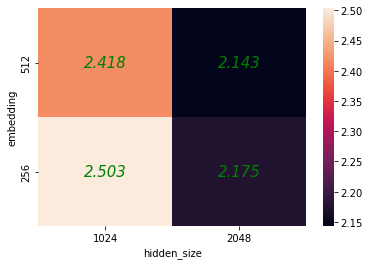

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

loss_=loss_df.pivot(index="embedding", columns="hidden_size", values="val_loss") 

loss_=loss_[['1024', '2048']]
loss_=loss_.reindex(["512","256"])

font3 = {'color':  'green',
      'style': 'italic',
      'size': 15}

sns.heatmap(loss_)
for i in range(loss_.shape[1]):
    for j in range(loss_.shape[0]):
        plt.text(i+0.5,j+0.5,round(loss_.iloc[j,i],3),ha='center',va='center', fontdict=font3)

plt.show()

validation loss가 2.2 이하인 모델은 hidden_size가 2048개인 모델 둘이 었다.  
그 중에서도 가장 성능이 좋았던 embedding_size=512, hidden_size=2048인 모델을 선택하였다.

In [33]:
from keras.models import load_model

model=TextGenerator(12000+1, 512, 2048) # i: embedding_size, j: hidden_size
optimizer=tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
model.compile(loss=loss, optimizer=optimizer)
model.fit(train_dataset, epochs=10, validation_data=(val_dataset))

Epoch 1/10
487/487 [==============================] - 272s 513ms/step - loss: 3.3075 - val_loss: 2.9033
Epoch 2/10
487/487 [==============================] - 272s 557ms/step - loss: 2.7270 - val_loss: 2.6305
Epoch 3/10
487/487 [==============================] - 273s 561ms/step - loss: 2.3960 - val_loss: 2.4448
Epoch 4/10
487/487 [==============================] - 273s 560ms/step - loss: 2.0771 - val_loss: 2.3118
Epoch 5/10
487/487 [==============================] - 273s 559ms/step - loss: 1.7839 - val_loss: 2.2161
Epoch 6/10
487/487 [==============================] - 273s 560ms/step - loss: 1.5290 - val_loss: 2.1521
Epoch 7/10
487/487 [==============================] - 274s 562ms/step - loss: 1.3230 - val_loss: 2.1277
Epoch 8/10
487/487 [==============================] - 274s 562ms/step - loss: 1.1694 - val_loss: 2.1278
Epoch 9/10
487/487 [==============================] - 275s 564ms/step - loss: 1.0700 - val_loss: 2.1454
Epoch 10/10
487/487 [==============================] - 274s 563m

In [34]:
generate_text(model, tokenizer, init_sentence="<start> i need you ", max_len=20)

'<start> i need you to be here with me <end> '

In [36]:
generate_text(model, tokenizer, init_sentence="<start> i said", max_len=20)

'<start> i said i m sorry girl <end> '

In [37]:
generate_text(model, tokenizer, init_sentence="<start> never let me go", max_len=20)

'<start> never let me go , keep breathing <end> '

In [41]:
generate_text(model, tokenizer, init_sentence="<start> you never ", max_len=20)

'<start> you never thought kanye would ever got that mad <end> '

In [42]:
generate_text(model, tokenizer, init_sentence="<start> why not ", max_len=20)

'<start> why not i trying to give when no one gives me a try <end> '

## 회고
- 언어모델을 돌려본 것 자체가 처음이었다. 물론 지난 프로젝트에 사용했던 가위바위보 모델 만들기도 시간이 오래걸렸지만, 하나의 모델을 만들기 위해서 10epoch를 돌리는데만해도 가장 작은 모델이 한 epoch당 40초 가량 시간이 들었다. 가장 무거운 모델은 한 에폭당 249초가 걸렸다. 학습시간이 오래 걸려서 모델을 돌려놓고 기다리다가 깜빡 졸았는데 너무 푹자버려서 다음날 아침에 일어나보니 LMS가 로그아웃 된 일도 있었고, 구글 colab에 모델을 걸어놓고 외출하고 돌아왔는데 오래 마우스 반응이 없어서 런타임이 종료된 일도 있었다. 이 사건을 계기로 꼭 모델을 만들고 어떻게하면 모델 저장하고 다시 로드해서 쓰는 방법을 꼭 익혀서 자칫 잘못해서 모델이 일부 날라가도 이어서 학습시킬수 있는 환경을 만들고 싶었다. 

-  위의 사연을 들은 유현지 퍼실님과 같은 조의 태원님과 대화중 callback기능을 알게 되었다. 다음에 모델을 만들때는 꼭 callback을 넣어서 모델을 만들어서 안전하게 학습을 해야겠다.

- 전반적으로 낯선 파트이라서 어려웠지만 자연어처리 데이터를 전처리하는 방법에 있어서 정규표현식을 자유자제로 다루는 스킬이 중요함을 느꼈다. 코드를 보면 전처리 과정에서 반 정도가 정규표현식의 패턴으로 데이터의 불필요한 정보는 지우는 일이 많았다. 정규표현식은 보통 필요할때 메뉴얼을 펼쳐놓고 하나씩 테스트하면서 정규식 표현식 패턴을 만들었는데 여러 케이스에 대해서 연습해서 익숙해져야겠다고 생각했다. 메타문자 '^'이 not을 의미하는지 몰라서 처음에 정규표현식을 잘못 이해했었다. 최소한 정규표현식의 메타표현식이 뭘 의미하는지는 숙지해야겠다고 생각했다.

- 노드에서 제시된 것처럼 대본의 텍스트를 다룰때는 문장 끝에 콜론이 붙을 경우(극본의 이름을 나타내는 표시) 그 문장을 포함시키지 않는등 NLP가 사용되는 텍스트에 대한 이해를 안다면 전처리를 더 수월하겠다는 생각을 했다. 

- 위의 히트맵을 보면 __embedding 사이즈가 높고, hidden의 사이즈가 큰쪽__ 이 loss가 많이 줄어들었음을 알수 있었다. validation loss가 2.2 아래로 떨어진 모델은 embedding은 512, hidden_size는 2048인 모델이다. 이정도면 모델의 복잡도가 큰 모델이라고 생각했었는데 검증데이터셋의 loss가 꾸준히 착착 줄어드는 것을 보고 NLP모델을 충분히 학습하고 결과물을 내기 위해서는 많은 리소스와 시간, 데이터를 필요로 하는 모델이라고 생각했다. 

- 사실 전처리 코드를 제출일 하루 전에 전처리 코드를 잘못 입력한 것을 발견해서 시간이 부족하여, 맨처음에 시도했던 embedding_size [128,256,512],hidden_size[512,1024,2048]. 총 9가지 케이스를 다시 돌려보지 못해서 아쉽다. 그래도 처음의 9번의 시도를 했던 당시와 같이 embedding_size와 hidden_size가 커질수록 학습의 손실(loss)과 검증데이터셋의 손실(loss)가 착착 줄어드는 것을 확인하였다. 그래서 최종적으로 embeding_size 512, hidden_size 2048인 모델을 선택해서 generate_text를 만들었다.